In [196]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [197]:
import torch 
import torch.nn as nn
import glob


from pathlib import Path
from collections import defaultdict

import core.experiment


from pytorch_utils.logging import LoggerReader
from pytorch_utils.evaluation import apply_model, argmax_and_accuracy
from nb_common import load_experiment_context, load_results

In [198]:
DEVICE = 'cuda:1'
RESULTS = None
# root = Path('/home/pma/chofer/repositories/toporeg_sandbox/results_generalization/')
#root = Path('/tmp/tmp_results')
root = Path('/tmp/debug')
# root = Path('/tmp/dummy')

DEVICE = 'cuda:1'

In [199]:
def compute_distances(path, run_i=0, train=True):
    Z, Y = compute_latent(path, run_i, train)
    
    labels = set(Y)
    assert labels == set(range(len(labels)))
    
    bs = 512
    
    ds_1 = torch.utils.data.dataset.TensorDataset(torch.tensor(Z), torch.tensor(Y))    
    dl_1 = torch.utils.data.DataLoader(ds_1, shuffle=False, batch_size=bs)
    
    list_D = []
    list_Y = []
    
    for batch_i, (x_1, y_1) in enumerate(dl_1):
        
        Z_, Y_ = ds_1.tensors
        Z_, Y_ = Z_[bs*batch_i:], Y_[bs*batch_i:]
        ds_2 = torch.utils.data.dataset.TensorDataset(Z_, Y_)
        dl_2 = torch.utils.data.DataLoader(ds_2, shuffle=False, batch_size=bs)
        
        for batch_j, (x_2, y_2) in enumerate(dl_2):    
                        
            D = (x_1.unsqueeze(0)*x_2.unsqueeze(1)).sum(dim=-1)
            
            Y = torch.cat([
                y_2.view(-1, 1, 1).expand(-1, x_1.size(0), -1),
                y_1.view(1, -1, 1).expand(x_2.size(0),-1, -1)
            ], dim=2)
            
            # we do not want innerproducts of the same samples ! 
            
            # Test that this is really implemented the right way
            #             y_1 = torch.tensor([0, 1, 2])
            #             y_2 = torch.tensor([3, 4, 5, 6])
            #             x_1 = torch.randn(3, 10)
            #             x_2 = torch.randn(4, 10)

            #             D = (x_1.unsqueeze(0)*x_2.unsqueeze(1)).sum(dim=-1)

            #             Y = torch.cat([
            #                 y_2.view(-1, 1, 1).expand(-1, x_1.size(0), -1),
            #                 y_1.view(1, -1, 1).expand(x_2.size(0),-1, -1)
            #             ], dim=2)

            #             for i, j in Y.view(-1, 2):
            #                 i = i -3

            #                 assert D[i, j].item() == (x_2[i]*x_1[j]).sum().item()
            
            if batch_j == 0:
                mask = torch.ones_like(D, dtype=torch.bool).triu(diagonal=1)
                
                D = D[mask]
                Y = Y[mask]
            
            Y = Y.sort(dim=-1)[0]
            
            list_D.append(D.view(-1))
            list_Y.append(Y.view(-1, 2))
            
                
    D, Y = torch.cat(list_D, dim=0), torch.cat(list_Y, dim=0)
    num_labels = len(labels)
    
    ret = {}
    for i in range(num_labels): 
        for j in range(i, num_labels):
            tmp_1 = Y[:, 0] == i
            tmp_2 = Y[:, 1] == j
            mask = tmp_1 & tmp_2 
            ret[i, j] = D[mask].numpy()
            
    return ret


r = compute_distances(load_results(root)[-1].path, train=True)

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/debug/12-09-2020-10-04-27__need_for_performance__49ae2c6e-586a-40d0-b9ff-5715b92a504e/0/model.pth'

In [ ]:
distances_inside_outside = []
for i in range(10):
    inside = r[i, i]    
    tmp = []
    for j in range(10):
        tmp.append(r[tuple(sorted((i, j)))])
        
    outside =  np.concatenate(tmp, axis=0)
    
    distances_inside_outside.append((inside, outside))
        
[(x.mean(), y.mean()) for x, y in distances_inside_outside]        

In [14]:
def compute_latent(path, run_i=0, train=True):
    exp_context = load_experiment_context(path, run_i=run_i)
    
    if train:
        ds = exp_context['ds_train']
    else:
        ds = exp_context['ds_test']
        
    feat_ext = exp_context['model'].feat_ext
    
    Z, Y = apply_model(dataset=ds, model=feat_ext, device=DEVICE)
    
    return Z, Y

def compute_cross_entropy_loss(path, run_i=0, train=True):
    exp_context = loretad_experiment_context(path, run_i=run_i)
    
    if train:
        ds = exp_context['ds_train']
    else:
        ds = exp_context['ds_test']
        
    Y_hat, Y = apply_model(dataset=ds, model=exp_context['model'], device=DEVICE)
    
    return torch.nn.functional.cross_entropy(
        torch.tensor(Y_hat), 
        torch.tensor(Y)
        , reduction='none').tolist()


def train_linear_cls(exp_context, weight_decay=0.001, lr=0.1, momentum=0, num_batches=1000, device='cuda'):
    
    ds_train = exp_context['ds_train']
    ds_test = exp_context['ds_test']
    
    dl_train = SubBatchDataLoader(
        ds_train, 
        num_batches,
        128,
        1,
        0
    )

    feat_ext = exp_context['model'].feat_ext.to(device)
    
    latent_dim = feat_ext(torch.randn(2, 3, 32, 32).to(device)).size(1)
    num_classes = exp_context['num_classes']
    
    classifier = nn.Linear(
        latent_dim, num_classes).to(device)
    classifier.train()

    opt = torch.optim.SGD(classifier.parameters(),
                          lr=lr, 
                          weight_decay=weight_decay, 
                          momentum=momentum)

    sch = torch.optim.lr_scheduler.CosineAnnealingLR(
        opt,
        num_batches,
        eta_min=0,
        last_epoch=-1)
    
    losses = []

    for batch_i, (batch_x, batch_y) in enumerate(dl_train):
        batch_x, batch_y = batch_x.to(
            device), batch_y.to(device)
        opt.zero_grad()

        with torch.no_grad():
            z = feat_ext(batch_x)

        y_hat = classifier(z)

        l = nn.functional.cross_entropy(y_hat, batch_y)
        losses.append(l.item())

        l.backward()
        opt.step()
        sch.step()
        

    m = nn.Sequential(feat_ext, classifier)
    X, Y = apply_model(dataset=ds_train, model=m, device=device)
    acc_train = argmax_and_accuracy(X, Y)
    
    X, Y = apply_model(dataset=ds_test, model=m, device=device)
    acc_test = argmax_and_accuracy(X, Y)
    
    return acc_train, acc_test, losses


In [15]:
l = compute_cross_entropy_loss(load_results(root)[-1].path, train=True)


In [27]:
l_sum = sum(l)

In [19]:
z, _ = compute_latent(load_results(root)[-1].path, train=True)

In [44]:
x_norm_min = torch.tensor(z).norm(p=2, dim=1).min()
x_norm_min

tensor(2.8126)

In [41]:
np.log(np.exp(l_sum) - 1)/x_norm_min

tensor(13.5159)

In [34]:
exp_context = load_experiment_context(load_results(root)[-1].path)
W = exp_context['model'].cls.weight
W.size()

torch.Size([10, 512])

In [39]:
W_norm = W.norm(p=2, dim=1)
(W_norm.unsqueeze(0) - W_norm.unsqueeze(1)).abs().max()

tensor(15.5326, grad_fn=<MaxBackward1>)

In [4]:
def plt_innerprod_to_mean(idx):
    path = RESULTS[idx].path 
    print(RESULTS[idx].experiment_args)
    Z_train, Y_train = compute_latent(path, train=True)
    Z_test, Y_test = compute_latent(path, train=False)
    
    def label_dict(X, Y):
        ret = defaultdict(list)
        assert len(X) == len(Y)
        for i in range(len(X)):
            ret[Y[i]].append(X[i])

        return ret

    Z_train_label = label_dict(Z_train, Y_train)
    Z_test_label = label_dict(Z_test, Y_test)
    
    anchors = {k: torch.tensor(v).mean(dim=0) for k, v in Z_train_label.items()}
    anchors = {k: v/torch.norm(v, p=2) for k, v in anchors.items()}
    
    for label, anchor in anchors.items():
        plt.figure()
        for name, Z_label in [('train', Z_train_label), ('test', Z_test_label)]:

            Z_l = Z_label[label]
            Z_l = torch.tensor(Z_l)

            inner_prod = Z_l*(anchor.unsqueeze(0))
            inner_prod = inner_prod.sum(dim=1)
            inner_prod = inner_prod.cpu().detach().numpy()
            plt.hist(inner_prod, label=str(name), bins=100, alpha=0.5, density=True)

            plt.legend()
            plt.grid()

{'num_runs': 1, 'output_root_dir': '/tmp/tmp_results/', 'num_batches': 100000, 'augment': 'standard', 'tag': 'different_scheduler', 'model': ['SimpleCNN13', {'batch_norm': True, 'drop_out': False, 'final_bn': True, 'compactification': 'sphere_l2', 'linear_bias': False, 'cls_norm': 'none', 'latent_dim': None}], 'batch_cfg': [4, {'+': 32, '-': 32}], 'lr_init': 0.1, 'momentum': 0.9, 'weight_decay': 0.001, 'ds_train': 'cifar10_train', 'ds_test': 'cifar10_test', 'energies': [['SphereRepulsion', {'sub_batch_agg': 'soft_min', 'temperature': 0.1, 'negatives_gradient': True}]], 'w_energies': None, 'eval_interval': 100000, 'evaluation_policies': ['optimized_linear', 'explicit_linear'], 'experiment_type': 'core.experiment_energy.ExpEnergy'}


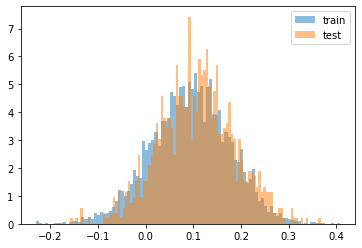

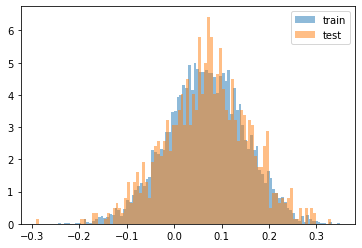

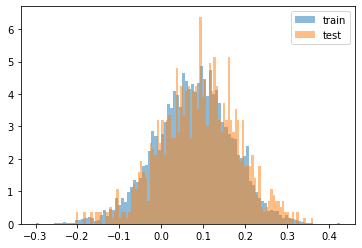

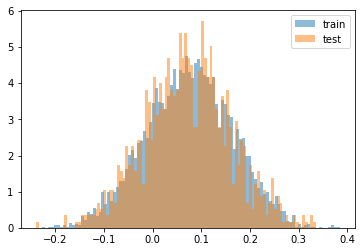

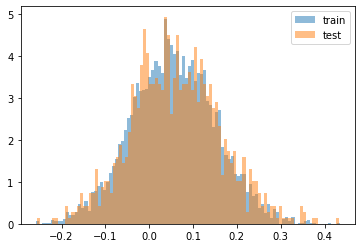

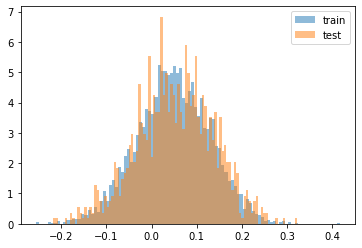

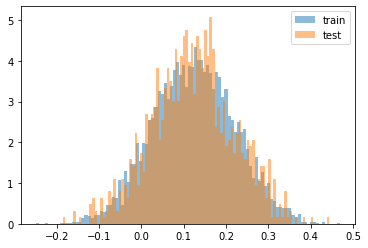

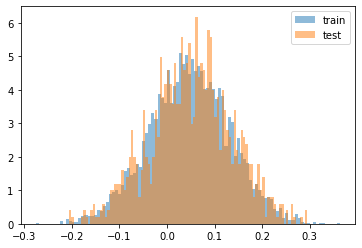

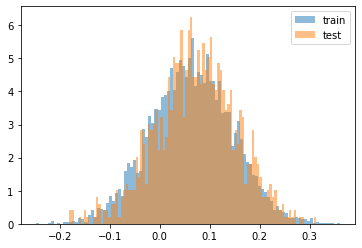

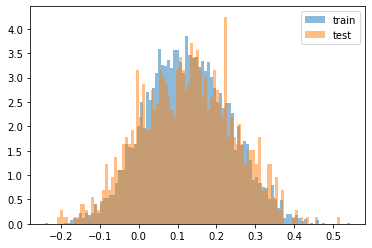

In [61]:
plt_innerprod_to_mean(23) #no attraction

{'num_runs': 1, 'output_root_dir': '/tmp/tmp_results/', 'num_batches': 100000, 'augment': 'standard', 'tag': 'different_scheduler', 'model': ['SimpleCNN13', {'batch_norm': True, 'drop_out': False, 'final_bn': True, 'compactification': 'sphere_l2', 'linear_bias': False, 'cls_norm': 'none', 'latent_dim': None}], 'batch_cfg': [4, {'+': 32, '-': 32}], 'lr_init': 0.01, 'momentum': 0.9, 'weight_decay': 0.001, 'ds_train': 'cifar10_train', 'ds_test': 'cifar10_test', 'energies': [['SphereRepulsion', {'sub_batch_agg': 'soft_min', 'temperature': 0.1, 'negatives_gradient': True}], ['SphereAttraction', {'sub_batch_agg': 'soft_max', 'temperature': 0.1}]], 'w_energies': None, 'eval_interval': 100000, 'evaluation_policies': ['optimized_linear', 'explicit_linear'], 'experiment_type': 'core.experiment_energy.ExpEnergy'}


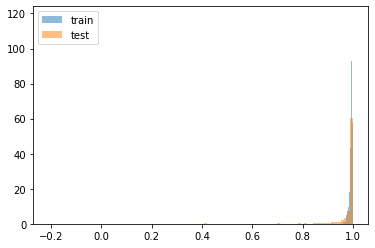

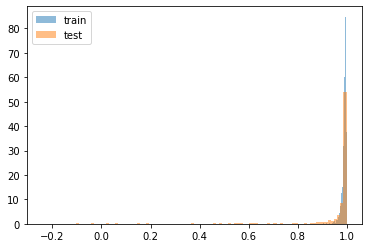

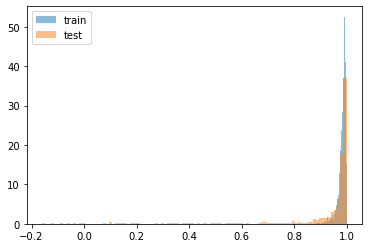

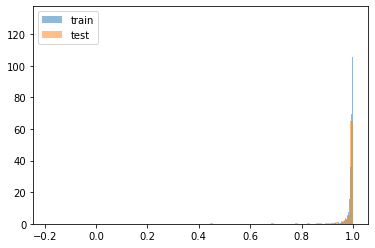

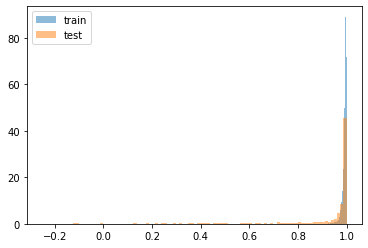

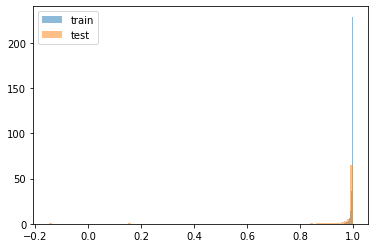

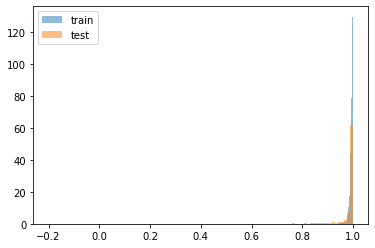

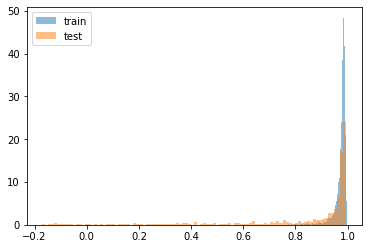

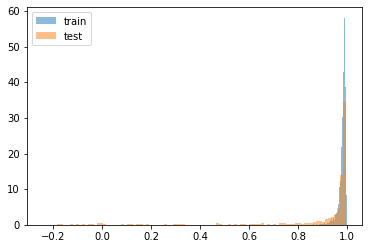

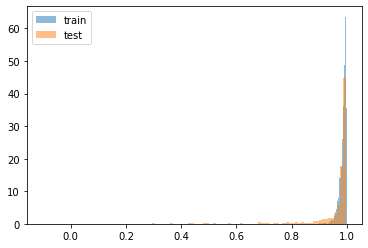

In [62]:
plt_innerprod_to_mean(16) # repulsion + attraction 

In [3]:
def evaluate_energies(path, energies, batch_cfg, train=True, num_batches=1000, device=DEVICE):
    
    if not isinstance(energies, list):
        energies = [energies]
    
    exp_context = load_experiment_context(path)
    
    ds = exp_context['ds_train'] if train else exp_context['ds_test']

    dl_train = SubBatchDataLoader(
        ds, 
        num_batches,
        batch_cfg[0],
        batch_cfg[1]['+'],
        batch_cfg[1]['-']
    ) 

    model = exp_context['model'].to(device)
    
    latent_dim = model(torch.randn(2, 3, 32, 32).to(device))[1].size(1)
    
    tmp = []
    for name, kwargs in energies:
        tmp.append(
            (name, getattr(core.experiment_energy, name)(
                batch_cfg[0], batch_cfg[1], **kwargs))
        )
    energies = tmp
        
    ret = defaultdict(list)
    for batch_i, (batch_x, batch_y) in enumerate(dl_train):
        batch_x, batch_y = batch_x.to(
            device), batch_y.to(device)

        with torch.no_grad():
             model_output = model(batch_x)

        for name, energy_fn in energies:
            e = energy_fn(model_output, batch_y, reduce=False)
            ret[name] = ret[name] + e.detach().cpu().tolist()
            
    return dict(ret)   

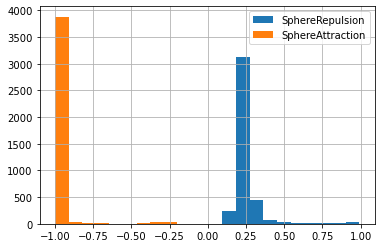

In [46]:
r = evaluate_energies(-1, 
                 [
                     ('SphereRepulsion', {'temperature': 0.1, 'sub_batch_agg': 'soft_min', 'negatives_gradient': False}),
                     ('SphereAttraction', {'temperature': 0.1, 'sub_batch_agg': 'soft_max'}),   
                 ],  
                 (4, {'+': 16, '-': 16}),
                 num_batches=1000)

plt.figure()
for k, v in r.items():
    plt.hist(v, label=k)
plt.legend()
plt.grid()

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/testing/10-21-2020-16-38-56__different_scheduler__0c37caf9-8f71-42e1-bc15-53741f08dd41/0/model.pth'

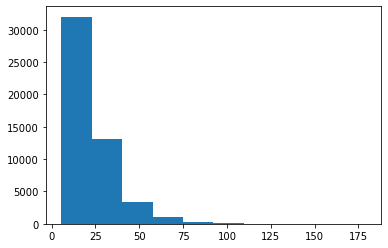

In [6]:
R = load_results(root)
for idx in [1, 11]:
    Z, Y = compute_latent(R[idx].path)
    Z = torch.tensor(Z)
    plt.figure()
    plt.hist(Z.norm(p=2, dim=1).numpy())
    